In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/AN2DL/Homework2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/AN2DL/Homework2


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [5]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(training_data)

[[0.         0.         0.         ... 0.60277778 0.36759259 0.33148148]
 [0.         0.         0.         ... 0.6        0.46       0.396     ]
 [0.         0.         0.         ... 0.96048126 0.94650625 0.97714021]
 ...
 [0.         0.         0.         ... 0.52631579 0.58223684 0.55263158]
 [0.         0.         0.         ... 0.44559585 0.58549223 0.40414508]
 [0.         0.         0.         ... 0.54268293 0.6097561  0.59146341]]


In [6]:
training_data.shape

(48000, 2776)

In [7]:
def print_sequence(dataset, to_plot):
  figs, axs = plt.subplots(to_plot, 1, sharex=True, figsize=(17,17))
  n_elements = len(dataset)
  for i in range(to_plot):
    el = random.randrange(n_elements)
    axs[i].plot(dataset[el])
    axs[i].set_title(el)
  plt.show()

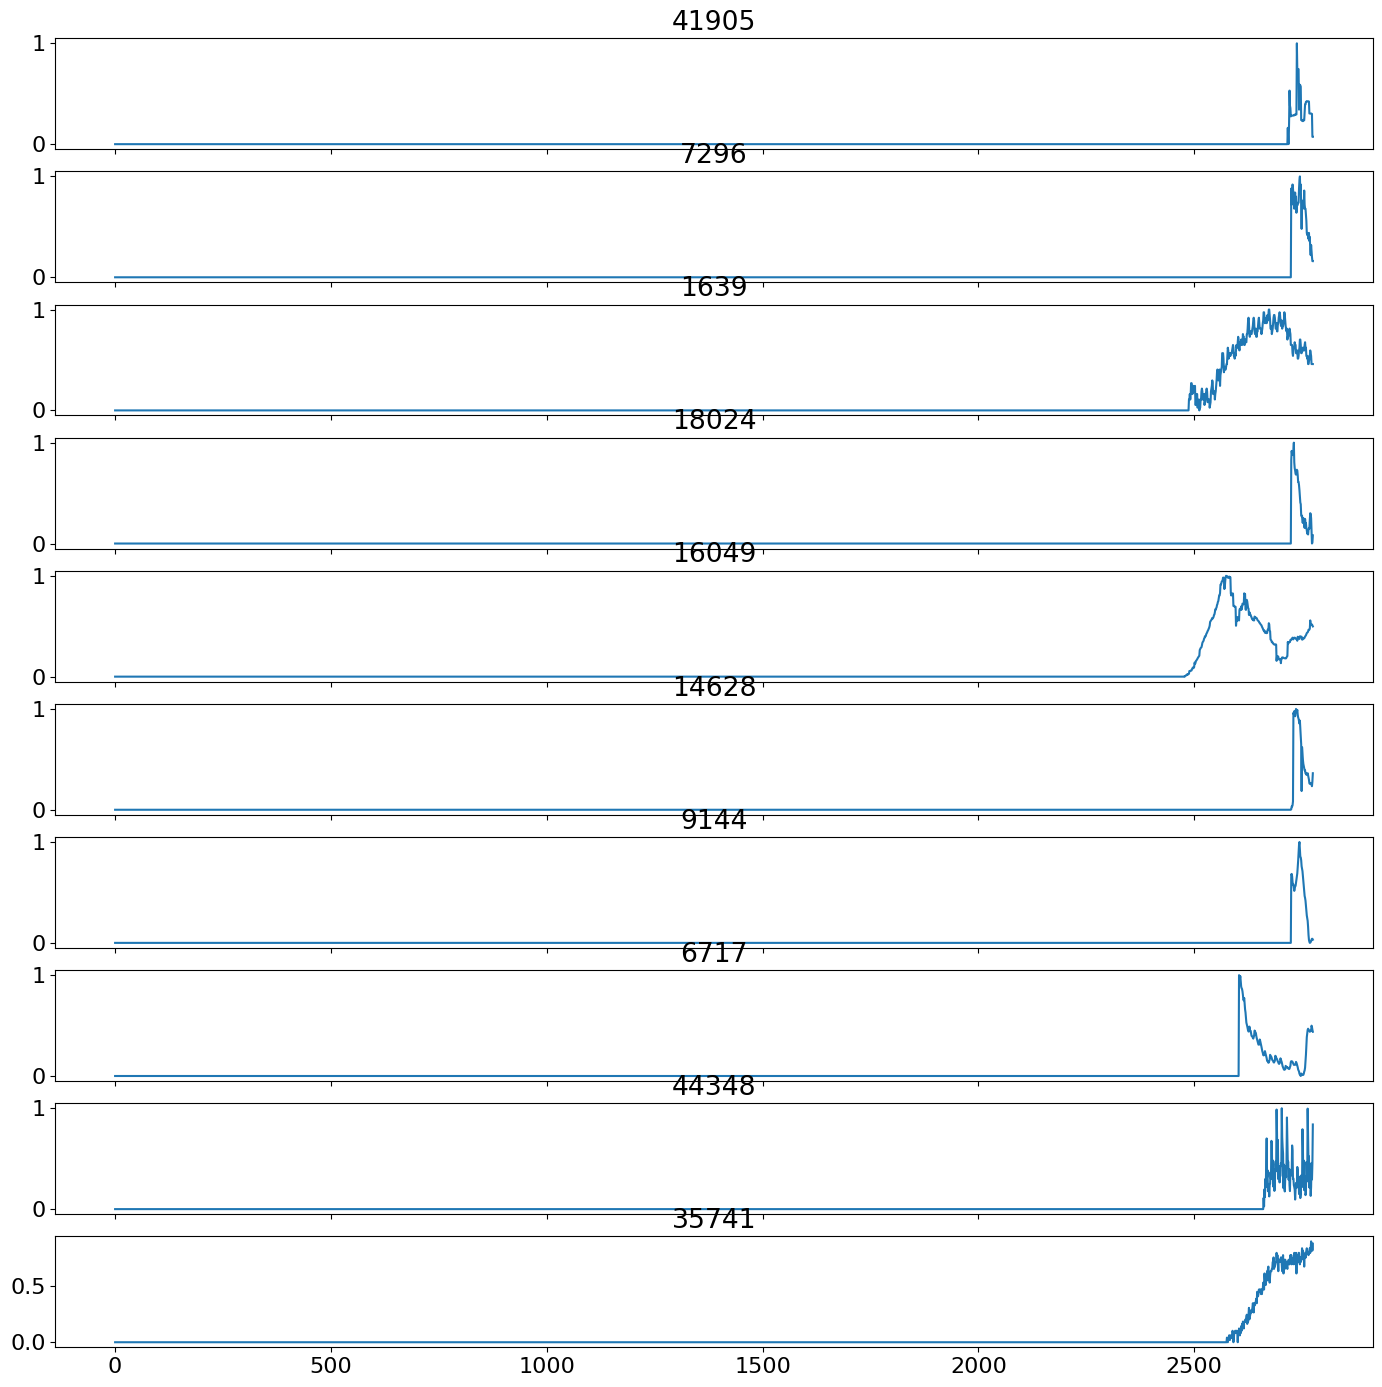

In [8]:
print_sequence(training_data, 10)

In [9]:
dataset = training_data

In [10]:
categories = np.load("categories.npy", allow_pickle=True)
print(categories)

['D' 'D' 'D' ... 'F' 'F' 'F']


In [11]:
valid_periods = np.load("valid_periods.npy", allow_pickle=True)
print(categories)

['D' 'D' 'D' ... 'F' 'F' 'F']


In [12]:
dataset = []
for i in range(training_data.shape[0]):
  dataset.append(training_data[i][valid_periods[i][0]: valid_periods[i][1]])

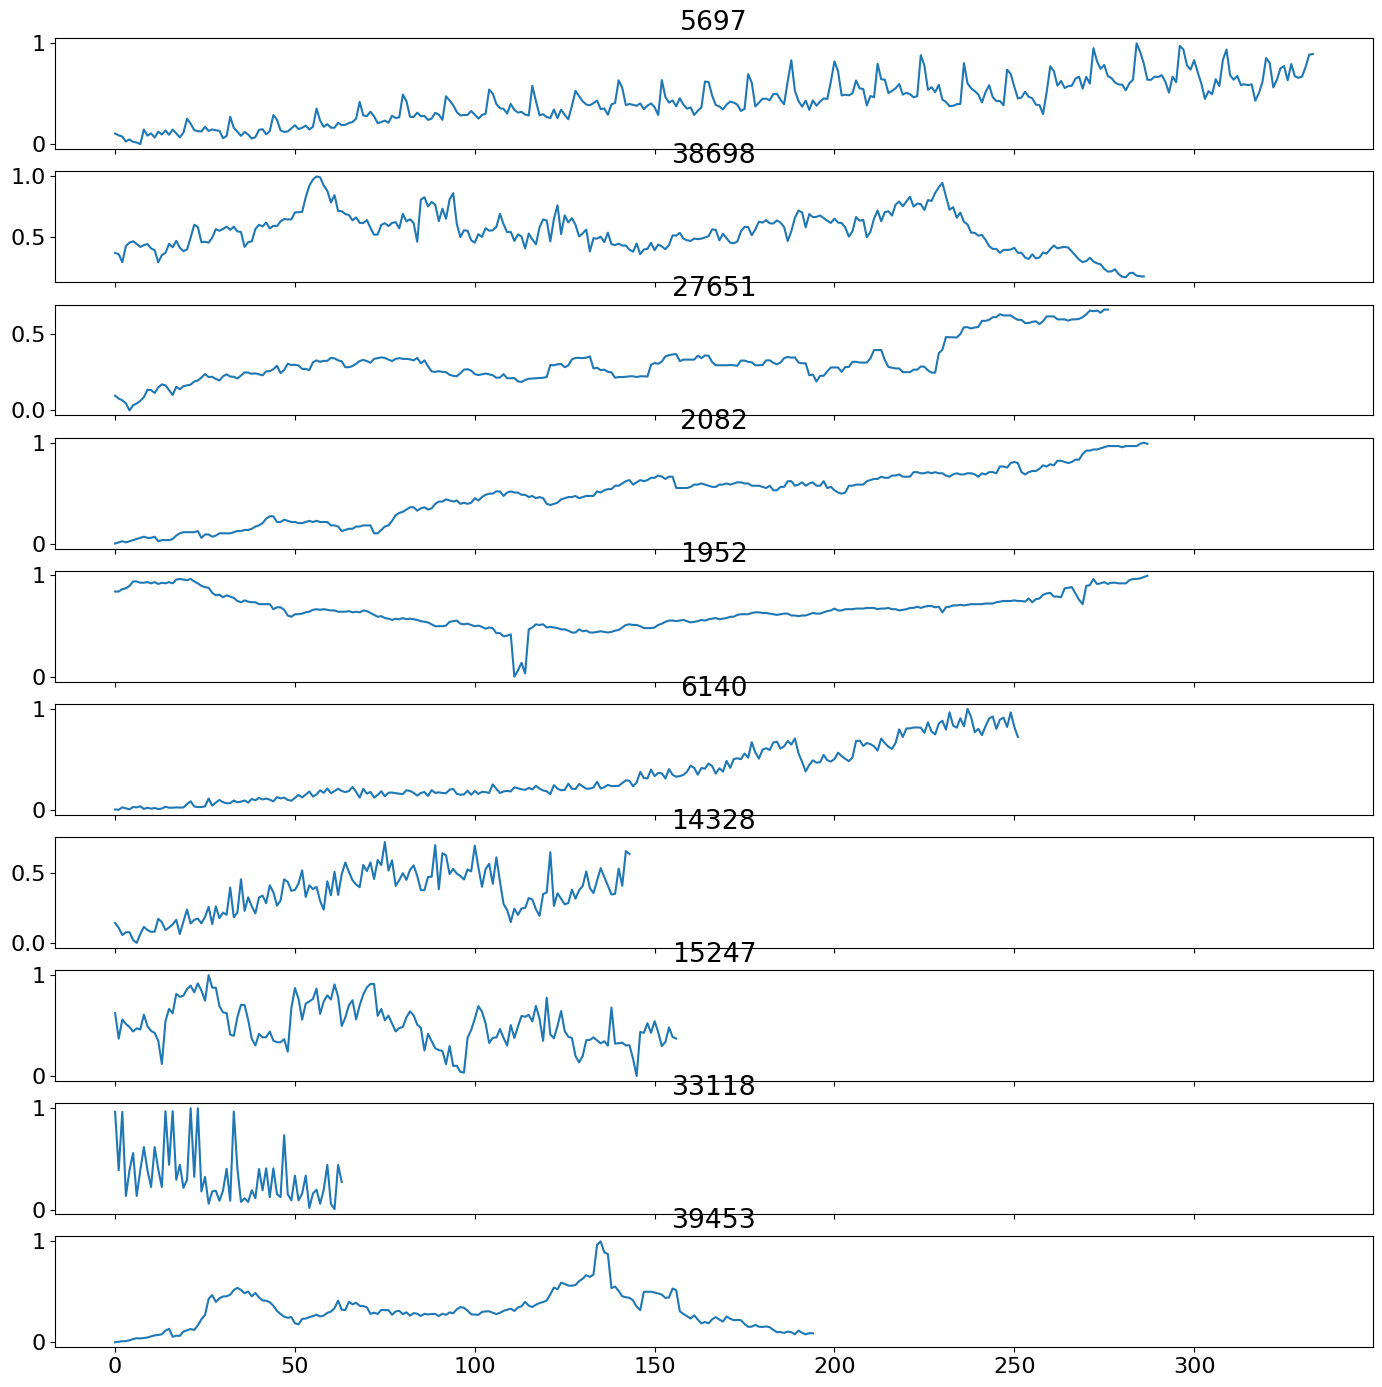

In [13]:
print_sequence(dataset, 10)

In [14]:
def split_train_test(dataset, percentage):
  X_train = []
  X_test = []
  for i in range(len(dataset)):
    pos = int(len(dataset[i])* percentage)
    train_el = dataset[i][:pos]
    test_el = dataset[i][pos:]
    X_train.append(train_el)
    X_test.append(test_el)
  return X_train, X_test

In [15]:
X_train, X_test = split_train_test(dataset, 0.80)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [16]:
print(X_train.shape)
print(X_test.shape)

(48000, 2220)
(48000, 556)


In [17]:
def build_sequences(df, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df.copy().values
    padding_check = len(df)%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
window = 100
stride = 5
telescope = 20
X_train, y_train = build_sequences(X_train, window, stride, telescope)
X_test, y_test = build_sequences(X_test, window, stride, telescope)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:

#X_test = pd.DataFrame(X_test)

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
print(input_shape)
print(output_shape)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history